In [1]:
import torch
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
print(dev)

c:\Users\BraboDeBH\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
import torch
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split

transform = transforms.Compose(
    [
        transforms.Resize(size=(299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5875, 0.5591, 0.4995], [0.2855, 0.2831, 0.3047]),
    ]
)

augmentation = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation((0,90)),
        transforms.Resize(size=(299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5875, 0.5591, 0.4995], [0.2855, 0.2831, 0.3047]),
    ]
)

train_data_path = 'DataSet/train/'
test_data_path = 'DataSet/test/'

dir_train = torchvision.datasets.ImageFolder(train_data_path,transform=transform)
dir_aug = torchvision.datasets.ImageFolder(train_data_path,transform=augmentation)
dir_train = torch.utils.data.ConcatDataset((dir_train,dir_aug))

dir_train = torchvision.datasets.ImageFolder(train_data_path,transform=transform)
train_data = torch.utils.data.DataLoader(dir_train,batch_size=128,shuffle=True,num_workers=8)

dir_test = torchvision.datasets.ImageFolder(test_data_path,transform=transform)
test_data = torch.utils.data.DataLoader(dir_test,batch_size=32,shuffle=True,num_workers=8)
len(train_data.dataset)

557

In [3]:
def train_one_epoch(NeuralNet,Loss,Optimizer,data_treino):
    NeuralNet.train(True)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0

    for i,data in enumerate(data_treino):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        Optimizer.zero_grad()
        output = NeuralNet(x)
        loss = Loss(output,y)
        current_loss += loss.item()
        loss.backward()
        Optimizer.step()
        
        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)

    return current_loss/(i+1), (current_accuracy/total_samples).to('cpu')

In [4]:
def validation_one_epoch(NeuralNet,Loss,val_data):
    NeuralNet.train(False)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = len(val_data.dataset)
    
    for i,data in enumerate(val_data):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        output = NeuralNet(x)
        loss = Loss(output,y)
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
    return current_loss/(i+1), (current_accuracy/total_samples).to('cpu')

In [5]:
from torch import nn
import torchvision.models as models

cnn = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
for i,param in enumerate(cnn.parameters()):
    param.requires_grad=False
cnn.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),
        )
cnn.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
from torch import nn
import torchvision.models as models

cnn = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for i,param in enumerate(cnn.parameters()):
    param.requires_grad=False
num_ftrs = cnn.fc.in_features
cnn.fc = nn.Linear(num_ftrs, 2)
cnn.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr=1e-3,momentum=0.9)

In [8]:
epochs = 30
train_loss_all_epoch = []
train_accuracy_all_epoch = []
val_loss_all_epoch = []
val_accuracy_all_epoch = []

for epoch in range(epochs):
    print(f'Starting epoch {epoch+1}')

    train_loss_per_epoch, train_accuracy_per_epoch = train_one_epoch(cnn,loss_function,optimizer,train_data)

    train_loss_all_epoch.append(train_loss_per_epoch)
    train_accuracy_all_epoch.append(train_accuracy_per_epoch)

    val_loss_per_epoch,val_accuracy_per_epoch = validation_one_epoch(cnn,loss_function,test_data)
    
    val_loss_all_epoch.append(val_loss_per_epoch)
    val_accuracy_all_epoch.append(val_accuracy_per_epoch)

    print(f'Train Loss: {train_loss_per_epoch}')
    print(f'Val Loss: {val_loss_per_epoch}')
    print(f'Train Accuracy: {train_accuracy_per_epoch}')
    print(f'Val Accuracy: {val_accuracy_per_epoch}')
    print()

print('Training process has finished.')

Starting epoch 1
Train Loss: 0.725085437297821
Val Loss: 0.7082210779190063
Train Accuracy: 0.34649911522865295
Val Accuracy: 0.4214285612106323

Starting epoch 2
Train Loss: 0.690043044090271
Val Loss: 0.6627995848655701
Train Accuracy: 0.4955116808414459
Val Accuracy: 0.699999988079071

Starting epoch 3
Train Loss: 0.6460757613182068
Val Loss: 0.6138255834579468
Train Accuracy: 0.6678635478019714
Val Accuracy: 0.7714285850524902

Starting epoch 4
Train Loss: 0.5903608798980713
Val Loss: 0.5766058683395385
Train Accuracy: 0.7648115158081055
Val Accuracy: 0.800000011920929

Starting epoch 5
Train Loss: 0.5437796831130981
Val Loss: 0.5367125809192658
Train Accuracy: 0.8294434547424316
Val Accuracy: 0.8642857074737549

Starting epoch 6
Train Loss: 0.5014103353023529
Val Loss: 0.49869956374168395
Train Accuracy: 0.8904847502708435
Val Accuracy: 0.8999999761581421

Starting epoch 7
Train Loss: 0.4569765210151672
Val Loss: 0.4660839974880219
Train Accuracy: 0.92998206615448
Val Accuracy: 0.

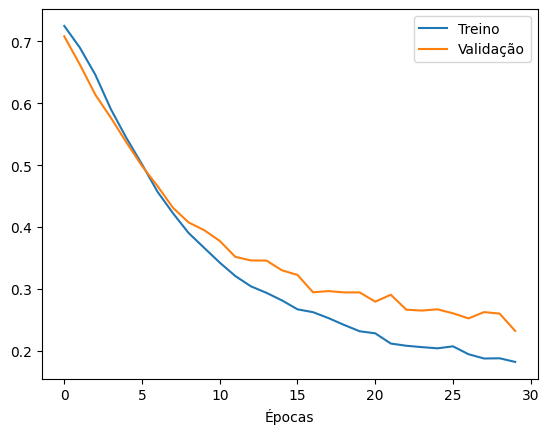

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_loss_all_epoch)
plt.plot(val_loss_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

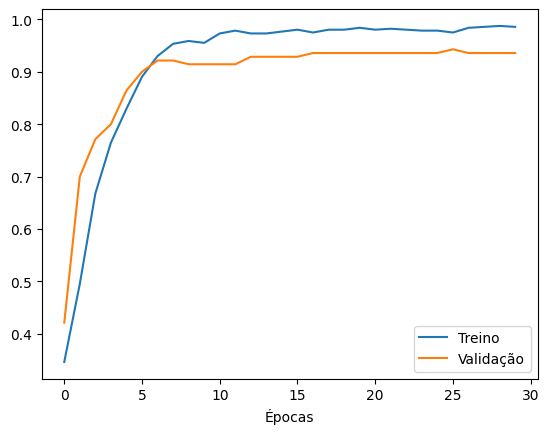

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy_all_epoch)
plt.plot(val_accuracy_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

In [11]:
from sklearn.metrics import classification_report

cnn.train(False)

all_pred = torch.tensor([]).to(device)
all_true = torch.tensor([]).to(device)

for data in test_data:
    x_test,y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = cnn(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    all_pred = torch.cat((all_pred,y_pred))
    all_true = torch.cat((all_true,y_test))

all_true = all_true.to('cpu')
all_pred = all_pred.to('cpu')
print(classification_report(all_true,all_pred,zero_division=1))

              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93        70
         1.0       0.92      0.96      0.94        70

    accuracy                           0.94       140
   macro avg       0.94      0.94      0.94       140
weighted avg       0.94      0.94      0.94       140



In [12]:
transform = transforms.Compose(
    [
        transforms.Resize(size=(299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5875, 0.5591, 0.4995], [0.2855, 0.2831, 0.3047])
    ]
)

dir_val = torchvision.datasets.ImageFolder('Teste',transform=transform)
val_data = torch.utils.data.DataLoader(dir_val,batch_size=32,shuffle=False,num_workers=0)

In [13]:
from sklearn.metrics import classification_report

cnn.train(False)

for data in val_data:
    x_test,y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = cnn(x_test)
    y_pred = y_pred.softmax(dim=1)
    print(y_pred)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    print(y_test,y_pred)

tensor([[0.7874, 0.2126],
        [0.1329, 0.8671],
        [0.2709, 0.7291],
        [0.2705, 0.7295],
        [0.0918, 0.9082]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0, 1, 1, 1, 1], device='cuda:0') tensor([0, 1, 1, 1, 1], device='cuda:0')
